# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [247]:
# Сделаем необходимые импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn

In [248]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10
train_data = torchvision.datasets.CIFAR100(root='lecture_02/', 
                                          train=True,
                                          transform=torchvision.transforms.ToTensor(),
                                          download=True)
test_data = torchvision.datasets.CIFAR100(root='lecture_02/', 
                                         train=False,
                                         transform=torchvision.transforms.ToTensor(),
                                         download=True)

Files already downloaded and verified
Files already downloaded and verified


In [249]:
train_data

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: lecture_02/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [250]:
test_data

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: lecture_02/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [497]:
target_list = train_data.classes
target_list[train_data[2][1]]

'apple'

In [523]:
def show_cifar(batch, num=4):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        ax = plt.subplot(np.sqrt(num), np.sqrt(num), i + 1)
        plt.imshow(batch[i][0].permute(1, 2, 0))
        ax.set_title(target_list[batch[i][1]])
        
    
    

/var/folders/lw/sfx9kxt17jj8cb5s59ll44q80000gp/T/ipykernel_84177/676645789.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(np.sqrt(num), np.sqrt(num), i + 1)


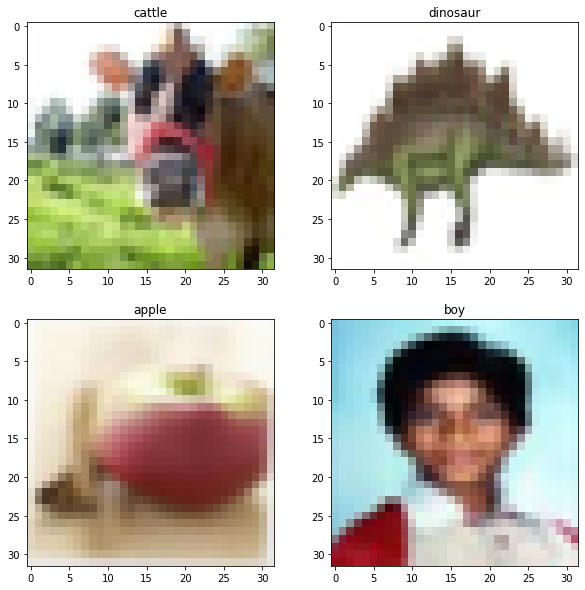

In [524]:
show_cifar(train_data)

In [275]:
train_loader = torch.utils.data.DataLoader(train_data,
                                                 batch_size=64,
                                                 shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=64,
                                               shuffle=False)

In [276]:
for x, y in test_loader:
    print(f'x shape {x.shape}')
    print(f'y shape {y.shape}')
    break

x shape torch.Size([64, 3, 32, 32])
y shape torch.Size([64])


In [372]:
input_size = 3 * 32 * 32
output_size = 100

3072

In [440]:
# Увы, не могу сказать, что справилась с написанием своей LeakyReLU
# решение честно найденно в гугле (хоть и не без труда) и немного модифицированно
# Проблем тут сразу несколько. К примеру я не понимаю как работает часть ActivationFunction и 
# зачем она нужна.
# Второе - сама модификация. Является-ли она правильной?
# Какие занчения х мы должны возвращать по итогу, (х * 0.5 | alpha * x * 0.1)
# или (х | alpha * x) ? 0.5 и 0.1 служат только условием, или с их помощью мы передаем
# дальше уменьшенные/увеличенные данные? Во втором варианте мне увиделось больше смысла, его я и 
# реализовала. Но вообще, если честно, я запуталась(
# Пробовала оба вариатна, резульат у нах одинаковый почему-то
class ActivationFunction(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}
        
    
class CustomLeakyReLU(ActivationFunction):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x * 0.5 > x * 0.1, x * 0.5, self.config["alpha"] * x * 0.1 )         

In [511]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

#  Тоже долго возилась, но в таком виде работает
# решила задавать внутренние слои вручную, без переменной - насколько оправданно?
class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1028)
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, output_dim)
 
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = CustomLeakyReLU()(x)
        x = self.fc2(x)
        x = CustomLeakyReLU()(x)
        x = self.fc3(x)
        x = CustomLeakyReLU()(x)
        x = self.fc4(x)
        x = CustomLeakyReLU()(x)
        x = self.fc5(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = CustomLeakyReLU()(x)
        x = self.fc2(x)
        x = CustomLeakyReLU()(x)
        x = self.fc3(x)
        x = CustomLeakyReLU()(x)
        x = self.fc4(x)
        x = CustomLeakyReLU()(x)
        x = self.fc5(x)
        x = nn.softmax(x)
        return x
    
    

In [512]:
model = MyNet(input_size, output_size)
print(model)

MyNet(
  (fc1): Linear(in_features=3072, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=100, bias=True)
)


In [513]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [514]:
# Запустить обучение (по аналогии с тем, что делали на паре)

# Надеюсь, я правильно посчитала здесь ошибку,
# даже в туториалах pytorch разные варианты были
# пожалуйста, прокомментируйте)

NUM_EPOCHS = 8
for i in range(NUM_EPOCHS):
    running_loss = 0.0
    for ind, el in enumerate(train_loader, 0):
        image, label = el[0], el[1]
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()
         
        running_loss += loss.item()
        if ind % 200 == 199:  
            print(f'[{i + 1}, {ind + 1 :5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
           

[1,   200] loss: 4.493
[1,   400] loss: 4.175
[1,   600] loss: 4.059
[2,   200] loss: 3.935
[2,   400] loss: 3.922
[2,   600] loss: 3.899
[3,   200] loss: 3.787
[3,   400] loss: 3.747
[3,   600] loss: 3.686
[4,   200] loss: 3.585
[4,   400] loss: 3.571
[4,   600] loss: 3.544
[5,   200] loss: 3.443
[5,   400] loss: 3.431
[5,   600] loss: 3.447
[6,   200] loss: 3.351
[6,   400] loss: 3.338
[6,   600] loss: 3.348
[7,   200] loss: 3.253
[7,   400] loss: 3.255
[7,   600] loss: 3.281
[8,   200] loss: 3.184
[8,   400] loss: 3.200
[8,   600] loss: 3.207


In [487]:
# Вот здесь я пыталась довести простроение сети до ума -
# не вышло, постоянно выпадаю с NotImplementedError, 
# подскажите пожалуйста, как это исправить
import torch.nn.functional as F
class Perceptron(nn.Module):
    
    def __init__(self, input_dim, output_dim, activation='CustomLeakyReLU'):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
            
        
    def perceptron_forvard(self, x):
        x = self.fc(x)
        if activation == 'CustomLeakyReLU':
            x = CustomLeakyReLU()(x)
            return x
        elif activation == 'softmax':
            return F.softmax(x)
        else:
            raise RuntimeError 
        
class FeedForvard(nn.Module):
    
    def __init__(self, input_dim):
        super(FeedForvard, self).__init__()
        self.fc1 = Perceptron(input_dim, 512)
        self.fc2 = Perceptron(512, 256 )
        self.fc3 = Perceptron(256, 128)
        self.fc4 = Perceptron(128, 100, 'softmax')

    def net_forvard(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [488]:
model = FeedForvard(input_size, 100)

In [489]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [490]:
NUM_EPOCHS = 5
for i in range(NUM_EPOCHS):
    running_loss = 0.0
    for ind, el in enumerate(train_loader, 0):
        image, label = el[0], el[1]
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()
         
        running_loss += loss.item()
        if ind % 200 == 199:  
            print(f'[{i + 1}, {ind + 1 :5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

NotImplementedError: 